<a href="https://colab.research.google.com/github/shihmujan/classs/blob/main/Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

In [ ]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap

In [ ]:
batch_size = 512
num_epochs = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from torchvision.models.resnet import resnet18
from torchvision.models import resnet34

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.first_layer = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3,stride=1, padding=0, bias=False),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
    )
    self.resnet = resnet18(pretrained=True)

    self.final = nn.Conv2d(512, 10, kernel_size=2, padding=0, bias=False)
    self.soft = nn.Softmax(dim=1)


  def forward(self, x):
    x = self.first_layer(x)
    x = self.resnet.layer1(x)
    x = self.resnet.layer2(x)
    x = self.resnet.layer3(x)
    x = self.resnet.layer4(x)
    x = self.final(x)
    x = x.view(x.shape[0], -1)
    x = self.soft(x)

    return x


# x = torch.randn(4,1,28,28).to('cuda')

# model = Net().to('cuda')

# print(model(x).shape)


In [ ]:
from tqdm import tqdm_notebook

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    trainloader = tqdm_notebook(train_loader)
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()

        trainloader.set_postfix(loss=loss.item())
        trainloader.set_description('epoch=' + str(epoch))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
from torchvision.transforms.transforms import RandomRotation
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                      transforms.RandomRotation(degrees=20),
                      transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Accuracy: 9793/10000 (98%)



  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Accuracy: 9841/10000 (98%)



In [ ]:
batch = next(iter(test_loader))
images, _ = batch

background = images[:100].to(device)
test_images = images[100:108]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

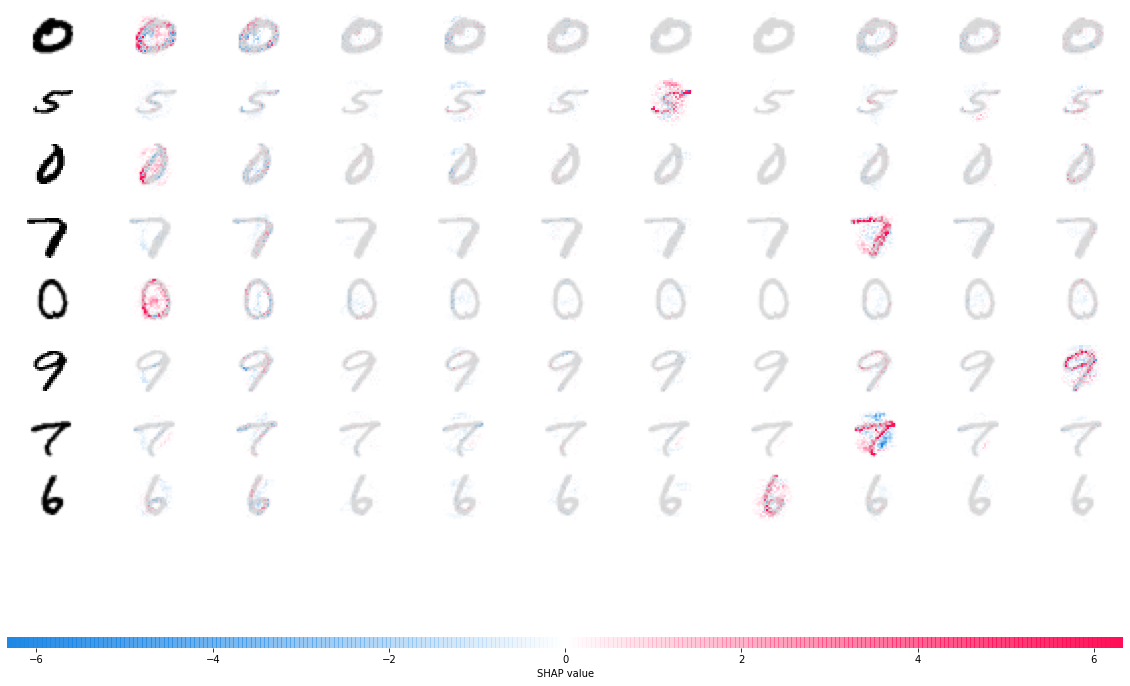

In [ ]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)